# Merging classification results

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import evaluate
import merge
import load

In [2]:
# Load evaluation data
test_columns = ['returnQuantity', 'articleID', 'productGroup', 'customerID', 'voucherID']
test_predictions = merge.merged_predictions(test=True, keep_columns=test_columns)
test_train = evaluate.test_complement(test_predictions)

# Load classification data
class_columns = ['articleID', 'productGroup', 'customerID', 'voucherID']
class_predictions = merge.merged_predictions(keep_columns=class_columns)
class_train = load.orders_train()

## Confidences: Imputation and Comparison 

The confidences contain NaN values, making imputation necessary before merge approaches based on confidence can be applied. Also is comparison complicated by the classifier's different confidence distributions, depicted in the figure below.

In [3]:
# Violinplot for class data and evaluation data
def confidence_plot(class_data, evaluation_data):  
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
    ax1.set_title('Classification')
    ax = sns.violinplot(data=class_data['confidence'], ax=ax1)
    ax2.set_title('Evaluation')
    ax = sns.violinplot(data=evaluation_data['confidence'], ax=ax2)

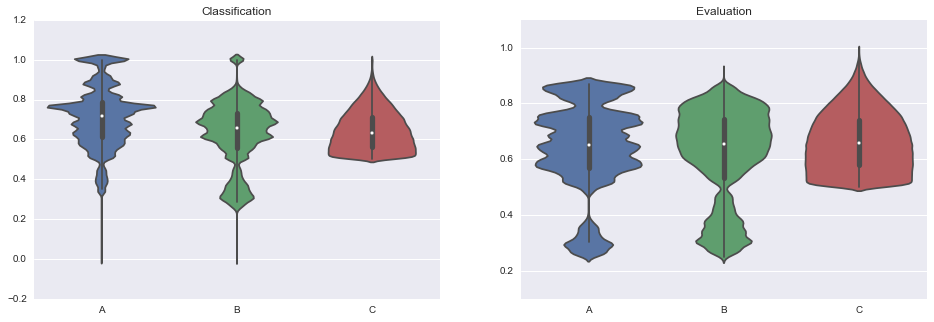

In [4]:
# Violinplot for original data
confidence_plot(class_predictions, test_predictions)

Instead of using the actual values, I propose to redefine the confidence in standard-deviations distance from the mean.

$$ conf_{i,c} = \frac{conf_{i,c} - \mu_c}{\sigma_c} $$

With $conf_{i,c}$ being the confidence of classification $c$ in row $i$. NaN values are filled with zeroes (then representing the mean).

The figure below shows the distributions of the imputed predictions.

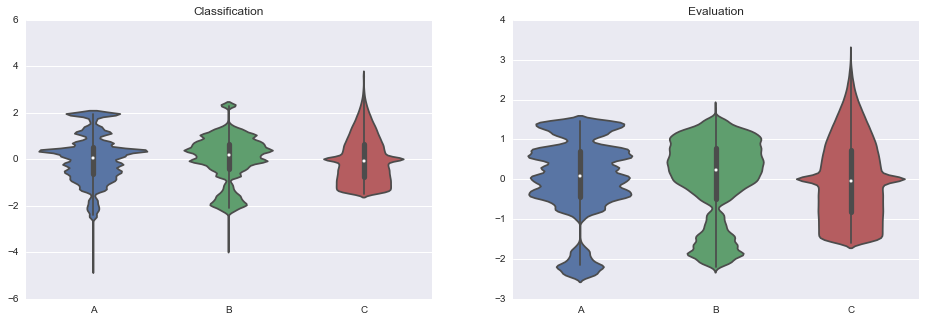

In [5]:
# Impute zeroes and convert confidenes to std-distances
class_imputed = merge.impute_confidences(class_predictions)
test_imputed = merge.impute_confidences(test_predictions)

# Violinplot for imputed data
confidence_plot(class_imputed, test_imputed)

## Approach 1: Weighted Majority Vode

We use the following formula for the final $prediction_i$, with $i$ being the row index. In it, each $prediction_{c,i}$ of classifier $c$ is weighted.

$$
row_i =
\dfrac
    {\sum_{c \in C}
        prediction_{c,i}
        \cdot weight_{c,i}}
    {\sum_{c \in C} weight_{c,i}}
$$

The $weight_{c,i}$ takes into account the condfidence of $c$ in row $i$, the mean confidence of $c$ over all rows, the overall accuracy of $c$ and the mean accuracy of all classifiers.

$$
weight_{c,i} = \dfrac{confidence_{c,i}}{confidence_{c,\varnothing}} \cdot \bigg(\dfrac{accuracy_c}{accuracy_\varnothing}\bigg)^2
$$

The confidences returned by the classifiers are, as such, not comparable to each other. They differ in meaning and in range. To counteract and to avoid favoring classifiers that are generally -maybe mistakenly- confident, we take the confidence compared to the classifier's mean confidence.

The accuracy, we believe, is the best predictor of a classifier's performance in the target set. We take this information from a test set that each group used to evaluate their classifier. The test set is a 70/30 split of the training data. We compare the accuracy to the mean accuracy of all classifiers. As the difference tends to be big in information, but small in extent, the ratio is squared.

In [6]:
mean_accuracies = evaluate.mean_accuracies(test_predictions)
merge.majority_vote(class_predictions, mean_accuracies)

NotImplementedError: 